In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat
import twixtools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import medfilt
from scipy.signal import butter,filtfilt
from scipy import ndimage

### Load data

In [2]:
import numpy as np
import os

# Base directory
base_dir = "/home/lilianae/projects/naf_recons/admm_test/mini_admm_rho_0.01_beta_0.0001/iters"

# Iteration to unpack
iter_num = 2
npz_path = os.path.join(base_dir, f"iter_{iter_num:03d}.npz")

# Load npz file
data = np.load(npz_path)

def reshape_mvf(mvf_flat, mvf_shape, num_gates):
    mvf = np.reshape(mvf_flat, (*mvf_shape, 3, num_gates), order='F')
    mvf = np.moveaxis(mvf, -1, 0)
    return mvf

# Inspect available arrays
print("Available arrays in npz:", data.files)

# Unpack
num_gates = 5
img_shape = (256, 256, 72) 
mvf_shape = (72, 256, 256) 
S_inv = reshape_mvf(data["S_inv"], mvf_shape, num_gates)      # shape: (num_gates, z, y, x, 3)
z_abs = np.abs(data["z"])      # shape: (num_gates, x, y, z)

print(f"S_inv.shape = {S_inv.shape}")
print(f"z_abs.shape = {z_abs.shape}")


Available arrays in npz: ['z', 'lam', 'u', 'S', 'S_inv']
S_inv.shape = (5, 72, 256, 256, 3)
z_abs.shape = (5, 72, 256, 256)


### Motion vector field statistics

In [3]:
for gate in range(num_gates):
    print(f'Gate {gate+1}:')
    print(" Motion vector statistics:")
    print(f"    X motion range: {S_inv[gate, :, :, :, 0].min():.3f} to {S_inv[gate, :, :, :, 0].max():.3f}")
    print(f"    Y motion range: {S_inv[gate, :, :, :, 1].min():.3f} to {S_inv[gate, :, :, :, 1].max():.3f}")
    print(f"    Z motion range: {S_inv[gate, :, :, :, 2].min():.3f} to {S_inv[gate, :, :, :, 2].max():.3f}")

    # Check for spatial coherence
    print(f"    Motion field shape: {S_inv.shape}")

    # Look at motion magnitude distribution
    magnitude = np.sqrt(np.sum(S_inv[0]**2, axis=-1))
    print(f"    Magnitude range: {magnitude.min():.3f} to {magnitude.max():.3f}")

Gate 1:
 Motion vector statistics:
    X motion range: -0.867 to 1.834
    Y motion range: -1.324 to 0.433
    Z motion range: -0.903 to 0.942
    Motion field shape: (5, 72, 256, 256, 3)
    Magnitude range: 0.000 to 1.856
Gate 2:
 Motion vector statistics:
    X motion range: -0.726 to 0.886
    Y motion range: -0.859 to 0.319
    Z motion range: -0.448 to 0.957
    Motion field shape: (5, 72, 256, 256, 3)
    Magnitude range: 0.000 to 1.856
Gate 3:
 Motion vector statistics:
    X motion range: 0.000 to 0.000
    Y motion range: 0.000 to 0.000
    Z motion range: 0.000 to 0.000
    Motion field shape: (5, 72, 256, 256, 3)
    Magnitude range: 0.000 to 1.856
Gate 4:
 Motion vector statistics:
    X motion range: -1.034 to 1.101
    Y motion range: -0.998 to 0.262
    Z motion range: -0.921 to 1.024
    Motion field shape: (5, 72, 256, 256, 3)
    Magnitude range: 0.000 to 1.856
Gate 5:
 Motion vector statistics:
    X motion range: -0.884 to 1.362
    Y motion range: -1.218 to 0.681


### View recons

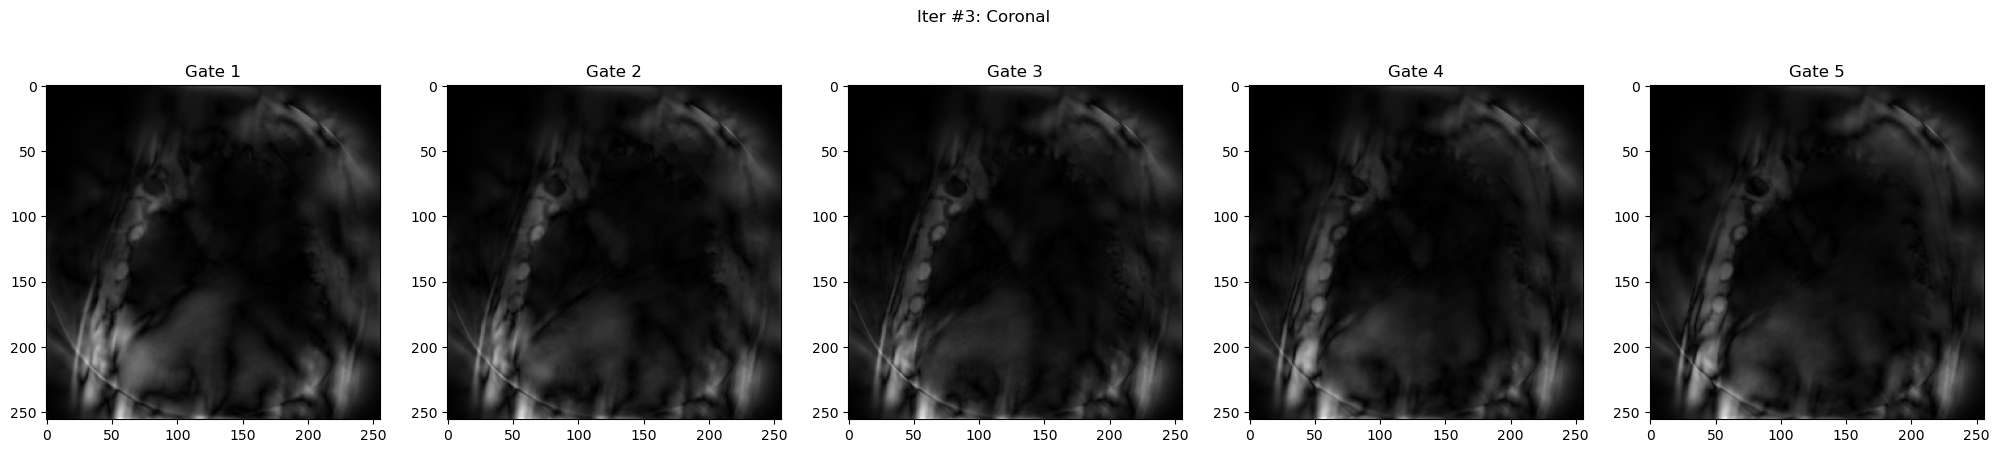

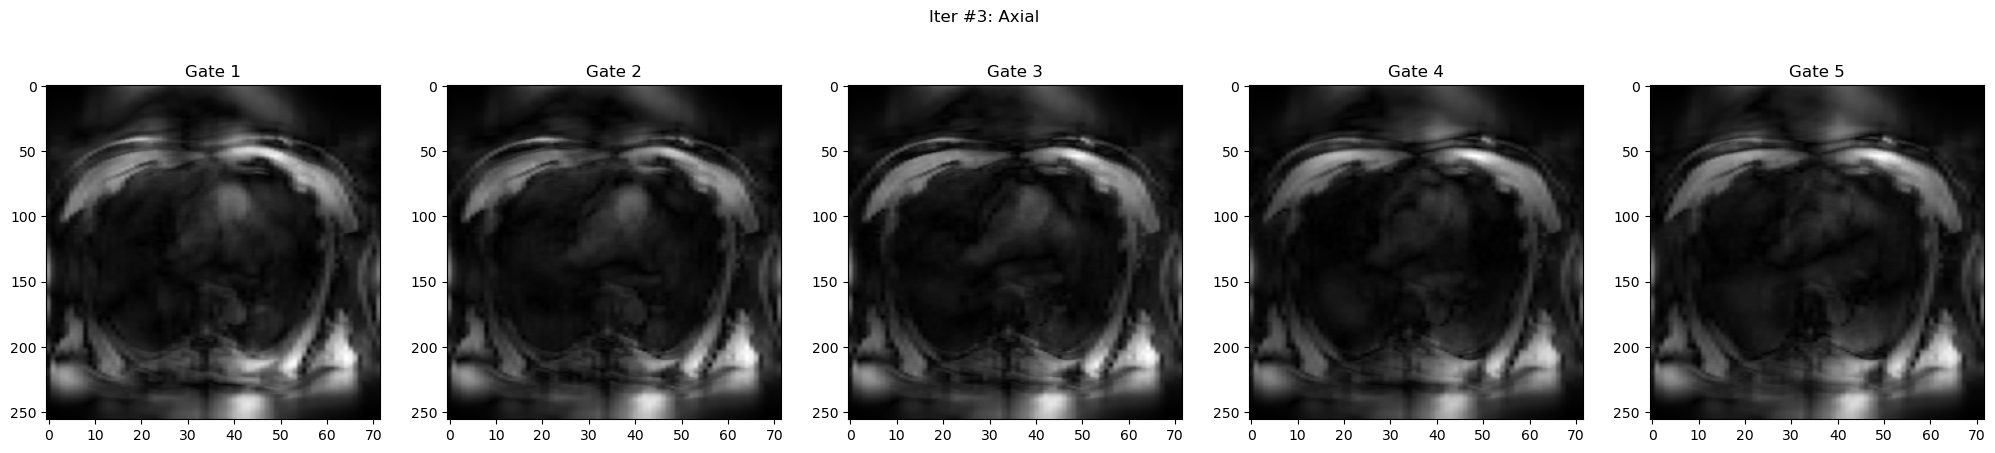

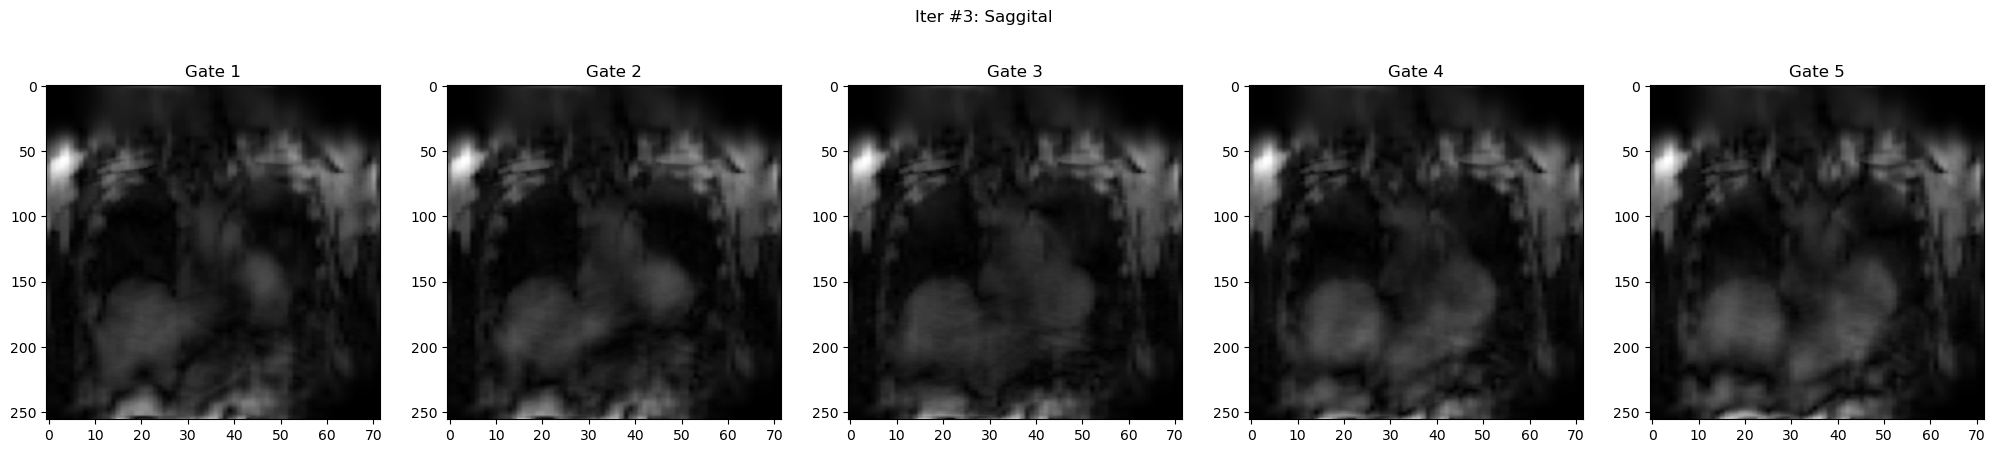

In [4]:
def rotate_180(img):
    return ndimage.rotate(img,180)

def visualize_gates(data, slice_axis=0, slice_idx=None, title=""):
    """
    Helper function to visualize slices of 3D data.
    """
    ngates= len(data)
    fig, axes = plt.subplots(1, ngates, figsize=(ngates*5, 5))
    aspect = 72/256
    gated_imgs = []
    for i in range(ngates):
        gate_data = data[i]
        if slice_idx is None:
            slice_idx = gate_data.shape[slice_axis] // 2
        
        if slice_axis == 0:  # axial
            slice_data = np.fliplr(gate_data[slice_idx, :, :])
            axis_name = "Coronal"
            aspect = 1.
        elif slice_axis == 1:  # sagittal  
            slice_data = np.fliplr(np.rot90(gate_data[:, slice_idx, :], k=1))
            axis_name = "Axial"
        elif slice_axis == 2:  # coronal
            slice_data = np.rot90(gate_data[:, :, slice_idx], k=-1)
            aspect = aspect
            axis_name = "Saggital"

        im0 = axes[i].imshow(np.abs(slice_data), cmap='gray', aspect=aspect)
        gated_imgs.append(np.abs(slice_data))
        axes[i].set_title(f'Gate {i+1}')
    fig.suptitle(f"Iter #3: {axis_name}")
    # plt.tight_layout()
    plt.show()
    return gated_imgs

# gated_imgs_init = visualize_gates(z_init, slice_axis=0)
gated_imgs_recon0 = visualize_gates(z_abs, slice_axis=0, slice_idx=44)
gated_imgs_recon1 = visualize_gates(z_abs, slice_axis=1)
gated_imgs_recon2 = visualize_gates(z_abs, slice_axis=2, slice_idx=150)

### Make gif

In [5]:
import imageio

titles = ['Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5']


# Create frames directory
os.makedirs("frames", exist_ok=True)

filenames = []
for i, (img, title) in enumerate(zip(gated_imgs_recon1, titles)):
    fig, ax = plt.subplots(figsize=(3, 3))
    # ax.imshow(img, cmap='gray', aspect=1.)  # aspect to preserve shape
    ax.imshow(img, cmap='gray', aspect=72/256)
    ax.axis('off')
    fname = f"frames/frame_{i:03d}.png"
    fig.savefig(fname, bbox_inches='tight')
    plt.close(fig)
    filenames.append(fname)

# Write GIF
gif_name = "axial_slice_admm_15_pt2_mid0082_lls_rho0.01_beta0.001.gif"
with imageio.get_writer(gif_name, mode='I', duration=0.8, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optional: cleanup
for filename in filenames:
    os.remove(filename)

print(f"GIF saved as {gif_name}")

GIF saved as axial_slice_admm_15_pt2_mid0082_lls_rho0.01_beta0.001.gif


/tmp/ipykernel_3538345/2476657120.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


### View MVFs as quiver plot

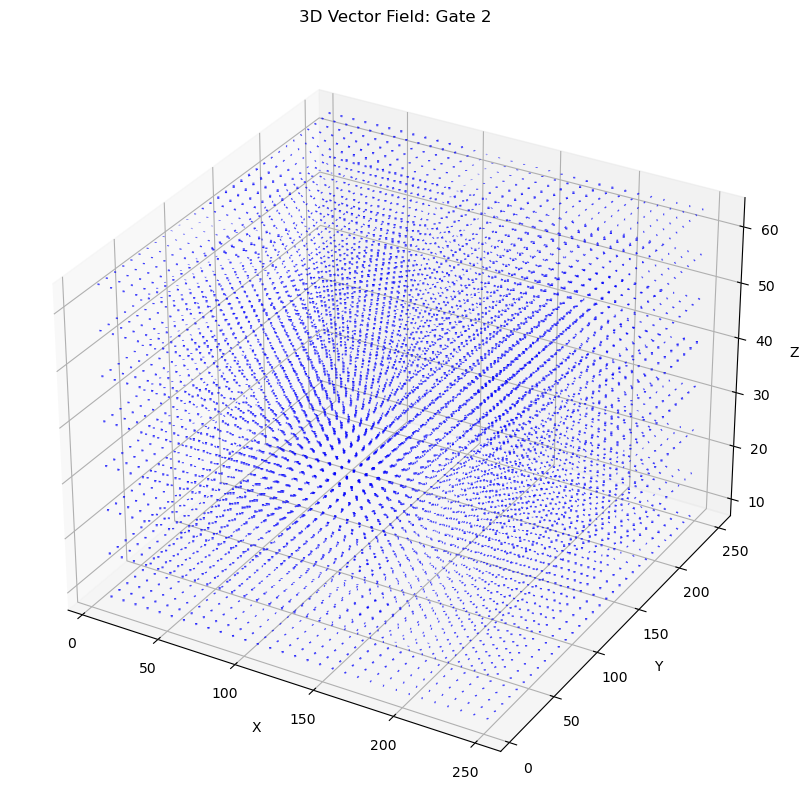

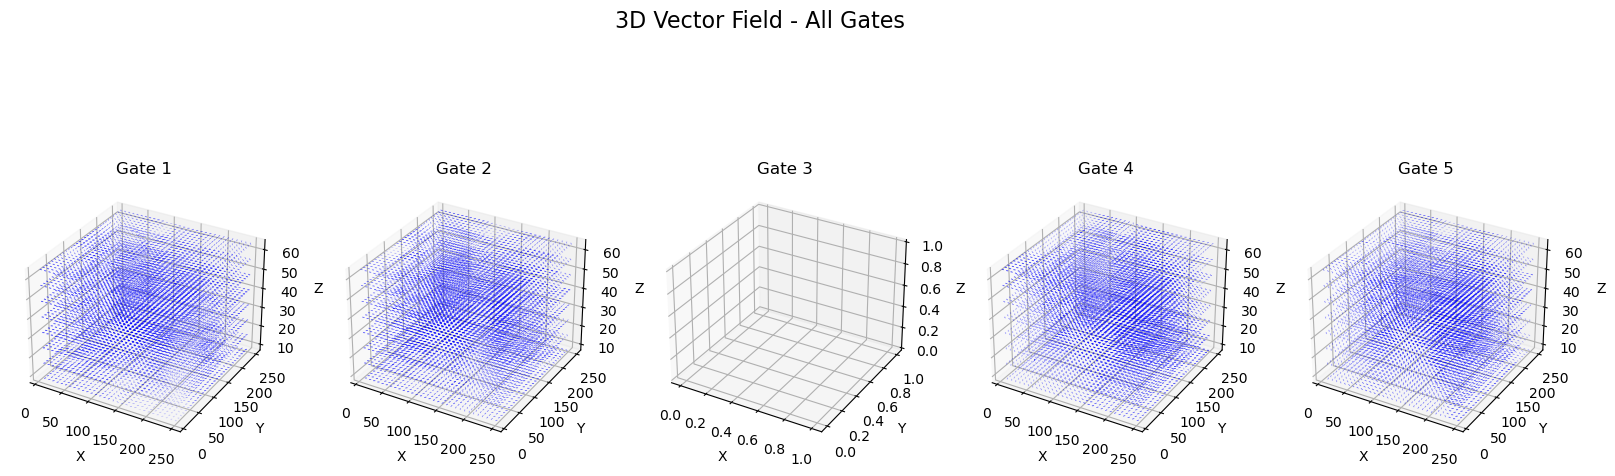

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_quiver(vector_field, gate, spacing=5, scale=1.0, alpha=0.6, 
                   color='blue', figsize=(12, 10), title="3D Vector Field"):
    """
    Create a 3D quiver plot for a 3D vector field.
    
    Parameters:
    - vector_field: 3D array of shape (x, y, z, 3) where the last dimension contains [u, v, w] components
    - spacing: spacing between vectors (higher = fewer vectors, cleaner plot)
    - scale: scaling factor for vector lengths
    - alpha: transparency of vectors
    - color: color of vectors
    - figsize: figure size
    - title: plot title
    
    Returns:
    - fig, ax: matplotlib figure and axes objects
    """
    
    ## Get dimensions
    
    vector_field_gate = vector_field[gate]
    nz, ny, nx, _ = vector_field_gate.shape
    
    ## Create coordinate grids with specified spacing
    x = np.arange(0, nx, spacing)
    y = np.arange(0, ny, spacing)
    z = np.arange(0, nz, spacing)
    Z, Y, X = np.meshgrid(z, y, x, indexing='ij')
    
    ## Extract vector components at grid points
    U = vector_field_gate[::spacing, ::spacing, ::spacing, 0]
    V = vector_field_gate[::spacing, ::spacing, ::spacing, 1]
    W = vector_field_gate[::spacing, ::spacing, ::spacing, 2]
    
    ## Create 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    ## Create quiver plot
    ax.quiver(X, Y, Z, U, V, W, 
              length=scale, normalize=True, alpha=alpha, color=color)
    
    ## Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title + f": Gate {gate+1}")
    
    plt.show()
    return fig, ax


def plot_3d_quiver_all_gates(vector_field, spacing=5, scale=1.0, alpha=0.6, 
                   color='blue', figsize=(20, 12), title="3D Vector Field - All Gates"):
    """
    Create a 3D quiver plot for a 3D vector field.
    
    Parameters:
    - vector_field: 3D array of shape (x, y, z, 3) where the last dimension contains [u, v, w] components
    - spacing: spacing between vectors (higher = fewer vectors, cleaner plot)
    - scale: scaling factor for vector lengths
    - alpha: transparency of vectors
    - color: color of vectors
    - figsize: figure size
    - title: plot title
    
    Returns:
    - fig, ax: matplotlib figure and axes objects
    """
    
    # Get dimensions
    
    num_gates = vector_field.shape[0]
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Different color for each gate
    
    # Create subplots - 1 row, 5 columns
    fig = plt.figure(figsize=figsize)
    axes = []
    

    for gate in range(num_gates):
        ## Create subplot
        ax = fig.add_subplot(1, 5, gate+1, projection='3d')
        axes.append(ax)

        # Get vector field for that gate
        vector_field_gate = vector_field[gate]
        nz, ny, nx, _ = vector_field_gate.shape

        x = np.arange(0, nx, spacing)
        y = np.arange(0, ny, spacing)
        z = np.arange(0, nz, spacing)
        Z, Y, X = np.meshgrid(z, y, x, indexing='ij')
        
        # Get vector components at grid points
        U = vector_field_gate[::spacing, ::spacing, ::spacing, 0]
        V = vector_field_gate[::spacing, ::spacing, ::spacing, 1]
        W = vector_field_gate[::spacing, ::spacing, ::spacing, 2]
        
        # Create 3D plot
        # fig = plt.figure(figsize=figsize)
        # ax = fig.add_subplot(111, projection='3d')
        
        # Create quiver plot
        ax.quiver(X, Y, Z,  U, V, W,
                length=scale, normalize=True, alpha=alpha, color=color)
        
        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Gate {gate+1}')
    
    fig.suptitle(title, fontsize=16, y =0.75)
    plt.tight_layout
    plt.show()
    return fig, ax




# Basic 3D quiver plot
## Single gate
fig, ax = plot_3d_quiver(S_inv, gate=1, spacing=8, scale=0.5)

## All gates
fig, ax = plot_3d_quiver_all_gates(S_inv, spacing=8, scale=0.5)